# Problem:
In this notebook We will try to find out the celebrity name on the basis of their image.

Input : will be a celebrity photo
Output: our machine will tell which celebrity it is

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

### UNZIPPING DATASET

In [3]:
path_to_zip_file = './sample_data/superstar_faces_dataset.zip'
directory_to_extract_to = './sample_data'

In [4]:
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)

# Replace the white space of the folder name

In [5]:
import os

# Define the path to the parent folder
parent_folder = "./sample_data/superstar_faces_dataset"

# Iterate through all subfolders in the parent folder
for folder_name in os.listdir(parent_folder):
    # Construct the full path to the subfolder
    folder_path = os.path.join(parent_folder, folder_name)

    # Check if it's a directory (subfolder)
    if os.path.isdir(folder_path):
        # Replace spaces with underscores in the folder name
        new_folder_name = folder_name.replace(" ", "_")
        new_folder_path = os.path.join(parent_folder, new_folder_name)

        # Rename the folder
        try:
            os.rename(folder_path, new_folder_path)
            print(f"Renamed: {folder_name} -> {new_folder_name}")
        except FileExistsError:
            print(f"Skipped: A folder with the name '{new_folder_name}' already exists.")
        except Exception as e:
            print(f"Error renaming '{folder_name}': {e}")
    else:
        print(f"Skipped: '{folder_name}' is not a folder.")

Renamed: Leonardo DiCaprio -> Leonardo_DiCaprio
Renamed: Johnny Depp -> Johnny_Depp
Renamed: Angelina Jolie -> Angelina_Jolie


In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 50
CHANNELS = 3

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./sample_data/superstar_faces_dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 300 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Angelina_Jolie', 'Johnny_Depp', 'Leonardo_DiCaprio']

(32, 256, 256, 3)
[1 2 0 0 0 2 1 2 2 1 2 0 2 2 2 0 2 0 0 2 0 1 1 2 0 1 1 1 1 1 0 1]


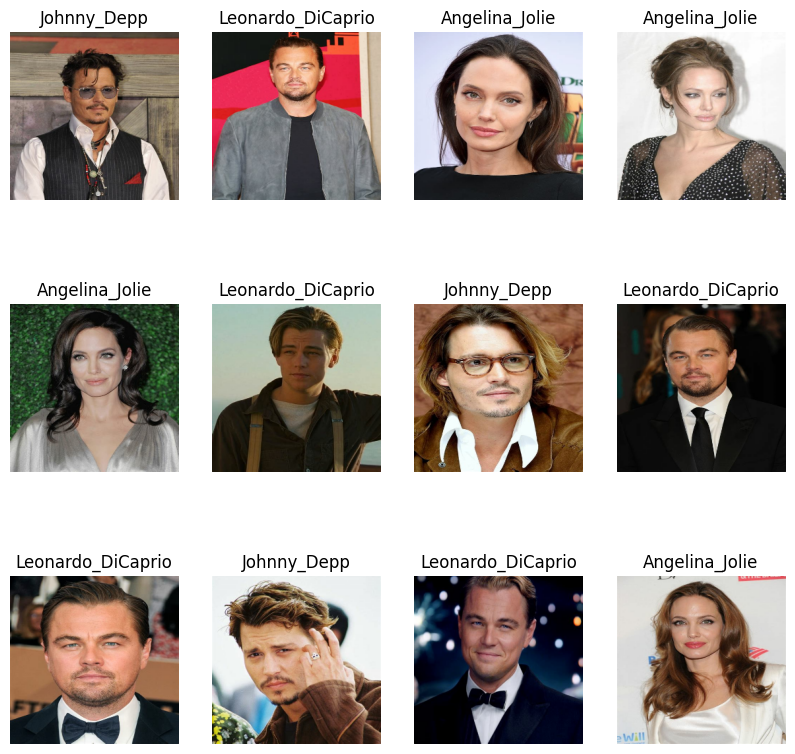

In [11]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.numpy().shape)
  print(labels_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [12]:
#convert data into train test split 80% training 10% validation 10% Testing
train_size = 0.8
len(dataset)*train_size

8.0

In [13]:
train_ds = dataset.take(54)
len(train_ds)

10

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [15]:
val_size = 0.1
len(dataset)*val_size

1.0

In [16]:
val_ds = train_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [18]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1,
                              test_split = 0.1, shuffle = True, shuffle_size = 100):
  assert(train_split + test_split + val_split) == 1
  ds_size =len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).take(val_size)

  return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(val_ds)

1

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [26]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.numpy())

[[[[  6.          8.          7.       ]
   [  6.          8.          7.       ]
   [  6.          8.          7.       ]
   ...
   [  7.          9.          8.       ]
   [  7.          9.          8.       ]
   [  7.          9.          8.       ]]

  [[  6.          8.          7.       ]
   [  6.          8.          7.       ]
   [  6.          8.          7.       ]
   ...
   [  7.          9.          8.       ]
   [  7.          9.          8.       ]
   [  7.          9.          8.       ]]

  [[  6.          8.          7.       ]
   [  6.          8.          7.       ]
   [  6.          8.          7.       ]
   ...
   [  7.          9.          8.       ]
   [  7.          9.          8.       ]
   [  7.          9.          8.       ]]

  ...

  [[ 15.143555    7.802368    5.095337 ]
   [ 14.000244   11.56311     7.437866 ]
   [ 11.2109375  13.464844    8.746094 ]
   ...
   [ 11.         13.         12.       ]
   [ 11.         13.         12.       ]
   [  6.5533447 

In [28]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [31]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size =(3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax'),

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.build(input_shape = input_shape)

In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203,075 (793.26 KB)

 Trainable params: 203,075 (793.26 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - accuracy: 0.3237 - loss: 1.1060 - val_accuracy: 0.4688 - val_loss: 1.0936
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.3197 - loss: 1.0987 - val_accuracy: 0.3438 - val_loss: 1.0978
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - accuracy: 0.3489 - loss: 1.0978 - val_accuracy: 0.2188 - val_loss: 1.0978
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.3706 - loss: 1.0965 - val_accuracy: 0.4375 - val_loss: 1.0792
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.3648 - loss: 1.0899 - val_accuracy: 0.3750 - val_loss: 1.1308
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.4170 - loss: 1.0566 - val_accuracy: 0.3750 - val_loss: 1.0807
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.3528 - loss: 1.0940 - val_accuracy: 0.4375 - val_loss: 1.0531
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.3202 - loss: 1.0971 - val_accuracy: 0.3125 - val_loss: 1.0722
Epoch 9/

In [37]:
score = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7188 - loss: 0.6528


In [38]:
score

[0.6528182625770569, 0.71875]

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
history.history['accuracy']

[0.30859375,
 0.31640625,
 0.3359375,
 0.3515625,
 0.38671875,
 0.40625,
 0.32421875,
 0.34375,
 0.34375,
 0.3828125,
 0.4609375,
 0.484375,
 0.51171875,
 0.484375,
 0.5,
 0.515625,
 0.51171875,
 0.484375,
 0.515625,
 0.5234375,
 0.48828125,
 0.51171875,
 0.54296875,
 0.53125,
 0.59765625,
 0.59375,
 0.58984375,
 0.55859375,
 0.57421875,
 0.58984375,
 0.6171875,
 0.65625,
 0.6796875,
 0.6484375,
 0.59765625,
 0.6171875,
 0.63671875,
 0.6640625,
 0.62890625,
 0.65625,
 0.6640625,
 0.66796875,
 0.69921875,
 0.6875,
 0.6953125,
 0.71484375,
 0.6953125,
 0.73046875,
 0.734375,
 0.76171875]

In [40]:
history.history['loss'][:5]

[1.106469750404358,
 1.098802924156189,
 1.0980583429336548,
 1.095392107963562,
 1.0803909301757812]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

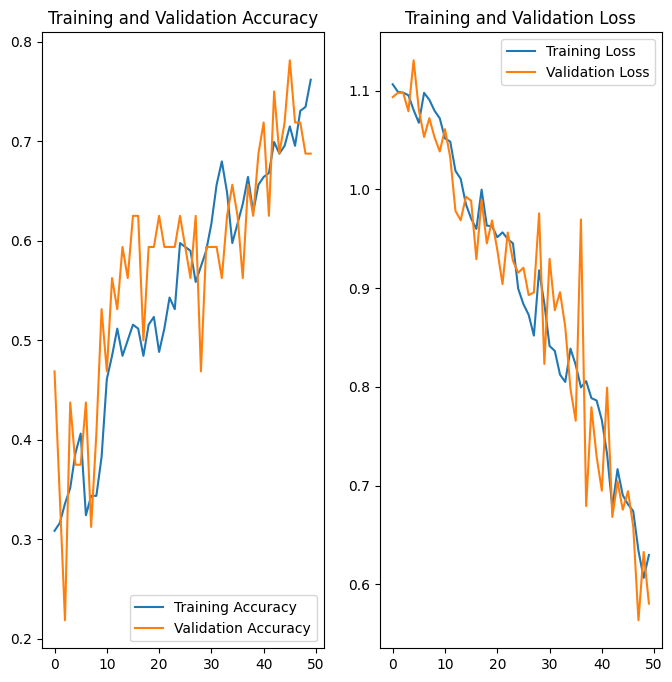

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Angelina_Jolie
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Angelina_Jolie


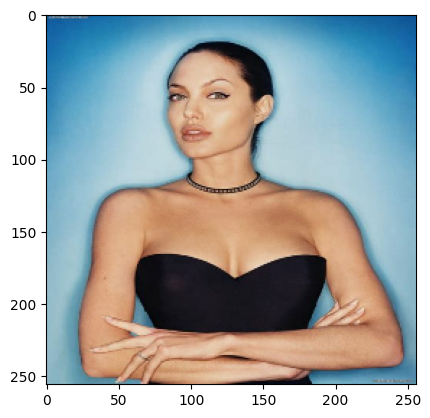

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


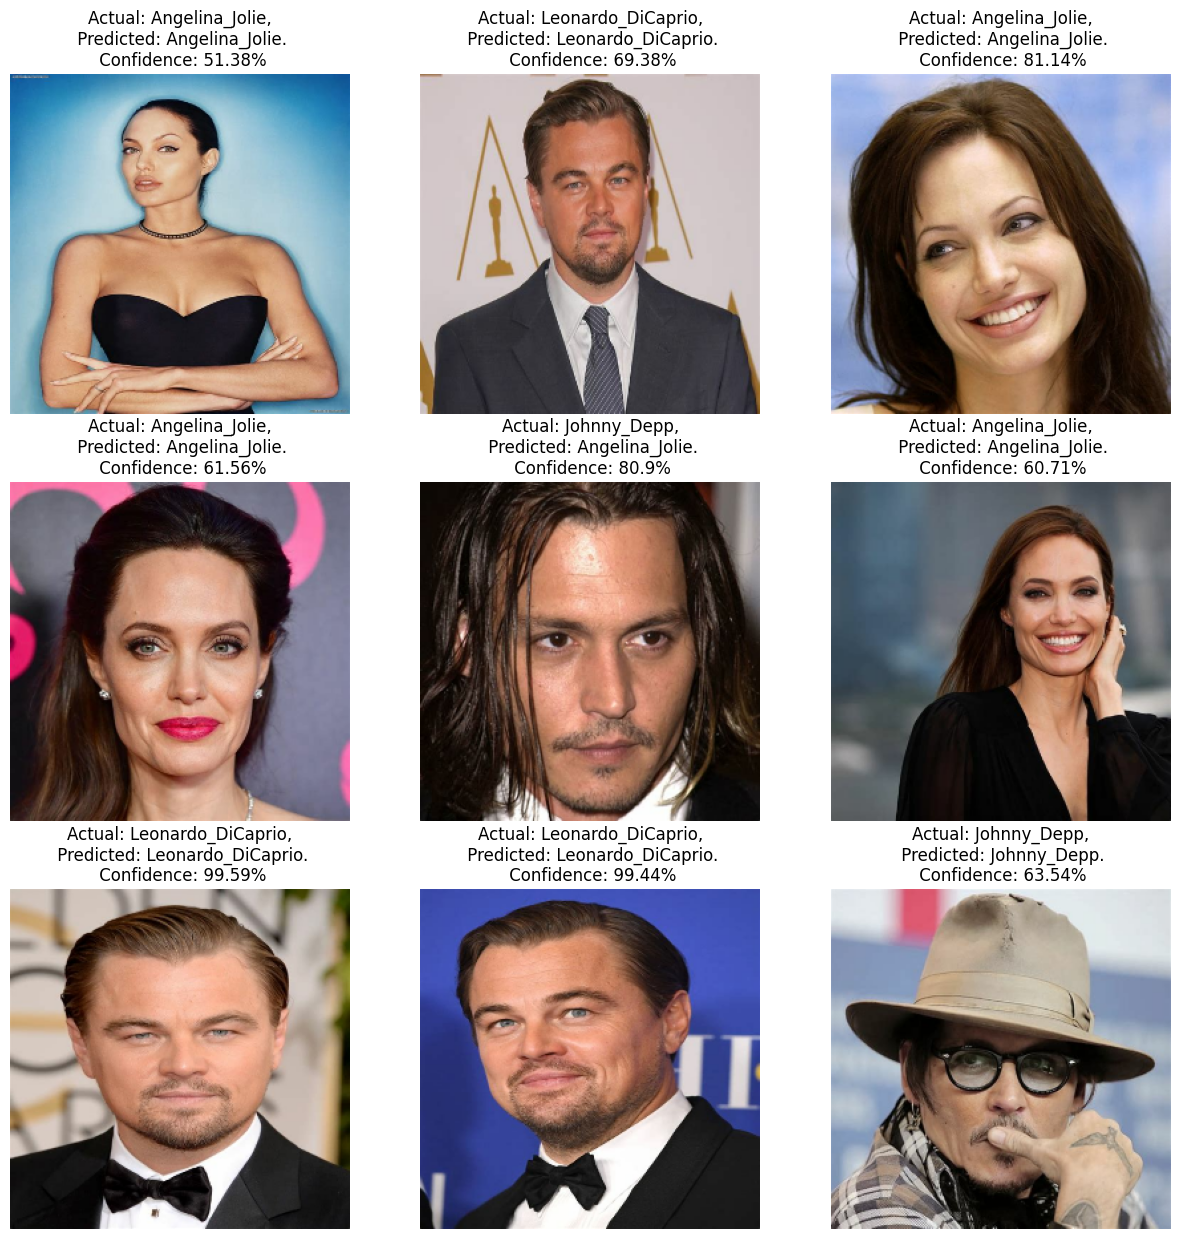

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")